<a href="https://colab.research.google.com/github/VUT-BA-3-2-Project-2025/Team-force/blob/Usher-Branch/TEAM_FORCE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#TeamForce Business Anylsis Project
#All neccessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Focus with logitsics dataset,
#Main goal of logistics dataset is to predict future demands (daily_demand, total_orders_last_month, last_restock_date, and category)
#calculate the most efficient pick-paths for employees (item_popularity_score, storage_location_id, zone, and picking_time_seconds)
#monitor inventory health and build anomaly detection models  (stock_level, reorder_point, stockout_count_last_month, and order_fulfillment_rate)

#read first 5
logistics_df = pd.read_csv("https://raw.githubusercontent.com/VUT-BA-3-2-Project-2025/Team-force/main/logistics_dataset.csv")
logistics_df.head()

In [13]:
#read the last 5
logistics_df.tail()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
3199,ITM13199,Groceries,343,21,12,2,39.88,1.30,0.34,L43,...,24.63,1.50,3,0.79,87,11.80,0.20,2024-11-28,237.04,0.545
3200,ITM13200,Electronics,428,43,5,7,2.68,4.25,0.91,L83,...,79.04,1.46,4,0.77,833,14.96,0.39,2024-11-28,34.00,0.605
3201,ITM13201,Groceries,415,80,14,5,49.15,5.41,0.14,L11,...,199.89,1.11,9,0.89,937,7.63,0.60,2024-10-02,62.57,0.509
3202,ITM13202,Groceries,173,84,3,9,43.39,8.47,0.69,L58,...,65.45,1.04,4,0.86,905,6.37,0.46,2024-03-30,36.96,0.565
3203,ITM13203,Apparel,377,40,14,3,29.40,7.43,0.14,L48,...,39.88,1.94,9,0.92,812,8.74,0.54,2024-05-25,193.91,0.435


In [16]:
#get summary info of dataset
logistics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   item_id                    3204 non-null   object        
 1   category                   3204 non-null   object        
 2   stock_level                3204 non-null   int64         
 3   reorder_point              3204 non-null   int64         
 4   reorder_frequency_days     3204 non-null   int64         
 5   lead_time_days             3204 non-null   int64         
 6   daily_demand               3204 non-null   float64       
 7   demand_std_dev             3204 non-null   float64       
 8   item_popularity_score      3204 non-null   float64       
 9   storage_location_id        3204 non-null   object        
 10  zone                       3204 non-null   object        
 11  picking_time_seconds       3204 non-null   int64         
 12  handli

In [19]:
logistics_df.describe()

,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,picking_time_seconds,handling_cost_per_unit,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
count,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204,3204.000000,3204.000000
mean,263.491573,54.759363,8.507803,5.578340,25.435868,5.260078,0.542325,95.606429,2.777116,105.887575,1.045993,4.602372,0.849738,521.714732,8.123677,0.600581,2024-07-04 09:30:47.191011328,154.286245,0.601737
min,20.000000,10.000000,3.000000,2.000000,1.010000,0.500000,0.100000,10.000000,0.500000,10.220000,0.100000,0.000000,0.700000,50.000000,1.000000,0.200000,2024-01-01 00:00:00,10.090000,0.259000
25%,144.000000,32.000000,5.000000,4.000000,13.535000,2.917500,0.310000,53.000000,1.660000,59.760000,0.580000,2.000000,0.780000,283.000000,4.590000,0.400000,2024-04-02 00:00:00,83.190000,0.527000
50%,264.000000,55.000000,9.000000,6.000000,25.405000,5.235000,0.540000,96.000000,2.810000,106.005000,1.050000,5.000000,0.850000,513.500000,8.150000,0.600000,2024-07-06 00:00:00,152.870000,0.601000
75%,386.000000,78.000000,12.000000,8.000000,37.412500,7.542500,0.760000,138.000000,3.910000,152.410000,1.522500,7.000000,0.920000,764.250000,11.692500,0.800000,2024-10-07 00:00:00,225.440000,0.677250
max,499.000000,99.000000,14.000000,9.000000,49.980000,10.000000,1.000000,179.000000,5.000000,200.000000,2.000000,9.000000,1.000000,999.000000,15.000000,1.000000,2024-12-30 00:00:00,299.940000,0.936000
std,138.568360,26.053354,3.473229,2.292486,14.038861,2.725639,0.259200,49.218084,1.305213,54.428161,0.550480,2.883708,0.086703,276.768531,4.069191,0.230511,NaN,82.945255,0.108286


In [11]:
logistics_df.shape

(3204, 23)

Data Cleaning

In [15]:
#according to info, last_restock_date is viewed as an object instead of
#so we converting last_restock_date to correct data type
logistics_df['last_restock_date'] = pd.to_datetime(logistics_df['last_restock_date'])

In [ ]:
#just a safe check, count missing numeric values in each field
missing_numeric_count = logistics_df.select_dtypes(include=['float64', 'int64']).isna().sum()
print(missing_numeric_count)

#swwet, no missing values in numeric data

In [20]:
#count missing object (string) fileds
missing_object_count = logistics_df.select_dtypes(include=['object']).isna().sum()
print(missing_object_count)

#confirmed, no missing data in any column

item_id                0
category               0
storage_location_id    0
zone                   0
dtype: int64


In [ ]:
#we already know columns needed for this model
#drop columns we dont need for this model
columns_to_drop = ['item_id','reorder_frequency_days','lead_time_days',
                   'demand_std_dev','handling_cost_per_unit','unit_price',
                   'holding_cost_per_unit_day','turnover_ratio',
                   'layout_efficiency_score','KPI_score',
                   'forecasted_demand_next_7d']
logistics_df = logistics_df.drop(columns=columns_to_drop)

# Display the first 5 rows of the updated DataFrame
logistics_df.head()

In [43]:
# --- Feature Engineering ---
if 'last_restock_date' in logistics_df.columns:
    ref_date = logistics_df['last_restock_date'].max()
    logistics_df['days_since_restock'] = (ref_date - logistics_df['last_restock_date']).dt.days.fillna(0)
else:
    logistics_df['days_since_restock'] = 0

#one-hot encode data so our model understands our data,
categorical_cols = ['category', 'zone']
logistics_df_encoded = pd.get_dummies(logistics_df, columns=categorical_cols, prefix=categorical_cols)
logistics_df_encoded.head()

,stock_level,reorder_point,daily_demand,item_popularity_score,storage_location_id,picking_time_seconds,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,last_restock_date,days_since_restock,category_Apparel,category_Automotive,category_Electronics,category_Groceries,category_Pharma,zone_A,zone_B,zone_C,zone_D
0,283,21,49.85,0.43,L82,106,0,0.80,700,2024-02-17,317,False,False,False,False,True,False,True,False,False
1,301,52,23.34,0.69,L15,45,3,0.79,736,2024-10-01,90,False,True,False,False,False,True,False,False,False
2,132,60,37.69,0.62,L4,177,7,0.75,814,2024-04-07,267,False,False,False,True,False,False,True,False,False
3,346,46,33.69,0.21,L95,39,0,0.96,994,2024-01-27,338,False,True,False,False,False,True,False,False,False
4,49,55,49.58,0.31,L36,35,5,0.83,299,2024-05-17,227,False,True,False,False,False,False,False,False,True


In [44]:
#mixmax scaler to avoid bias because of very large and very small numbers
scaler = MinMaxScaler()
numeric_cols = ['daily_demand', 'total_orders_last_month', 'stock_level',
                'reorder_point', 'stockout_count_last_month', 'order_fulfillment_rate',
                'item_popularity_score','picking_time_seconds','days_since_restock']
logistics_df_encoded[numeric_cols] = scaler.fit_transform(logistics_df_encoded[numeric_cols])
logistics_df_encoded.head()

,stock_level,reorder_point,daily_demand,item_popularity_score,storage_location_id,picking_time_seconds,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,last_restock_date,days_since_restock,category_Apparel,category_Automotive,category_Electronics,category_Groceries,category_Pharma,zone_A,zone_B,zone_C,zone_D
0,0.549061,0.123596,0.997345,0.366667,L82,0.568047,0.000000,0.333333,0.684932,2024-02-17,0.870879,False,False,False,False,True,False,True,False,False
1,0.586639,0.471910,0.455993,0.655556,L15,0.207101,0.333333,0.300000,0.722866,2024-10-01,0.247253,False,True,False,False,False,True,False,False,False
2,0.233820,0.561798,0.749030,0.577778,L4,0.988166,0.777778,0.166667,0.805058,2024-04-07,0.733516,False,False,False,True,False,False,True,False,False
3,0.680585,0.404494,0.667347,0.122222,L95,0.171598,0.000000,0.866667,0.994731,2024-01-27,0.928571,False,True,False,False,False,True,False,False,False
4,0.060543,0.505618,0.991832,0.233333,L36,0.147929,0.555556,0.433333,0.262381,2024-05-17,0.623626,False,True,False,False,False,False,False,False,True


EDA (Exploratory Data Analysis)

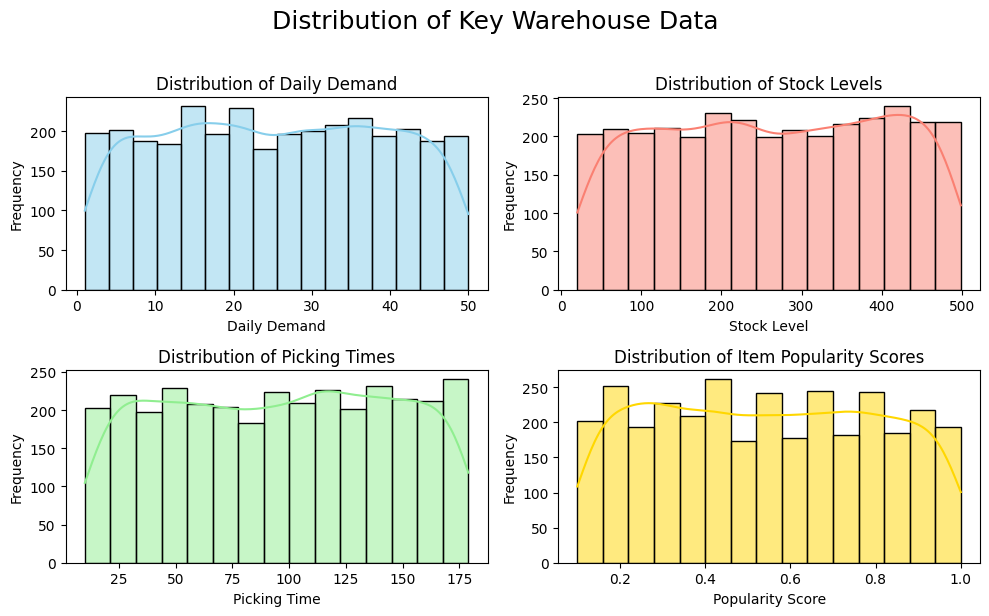

In [45]:
#Understand data distribution for each feature
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.histplot(logistics_df['daily_demand'], kde=True, color='skyblue')
plt.title('Distribution of Daily Demand')
plt.xlabel('Daily Demand')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(logistics_df['stock_level'], kde=True, color='salmon')
plt.title('Distribution of Stock Levels')
plt.xlabel('Stock Level')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(logistics_df['picking_time_seconds'], kde=True, color='lightgreen')
plt.title('Distribution of Picking Times')
plt.xlabel('Picking Time')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(logistics_df['item_popularity_score'], kde=True, color='gold')
plt.title('Distribution of Item Popularity Scores')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')

plt.suptitle('Distribution of Key Warehouse Data', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

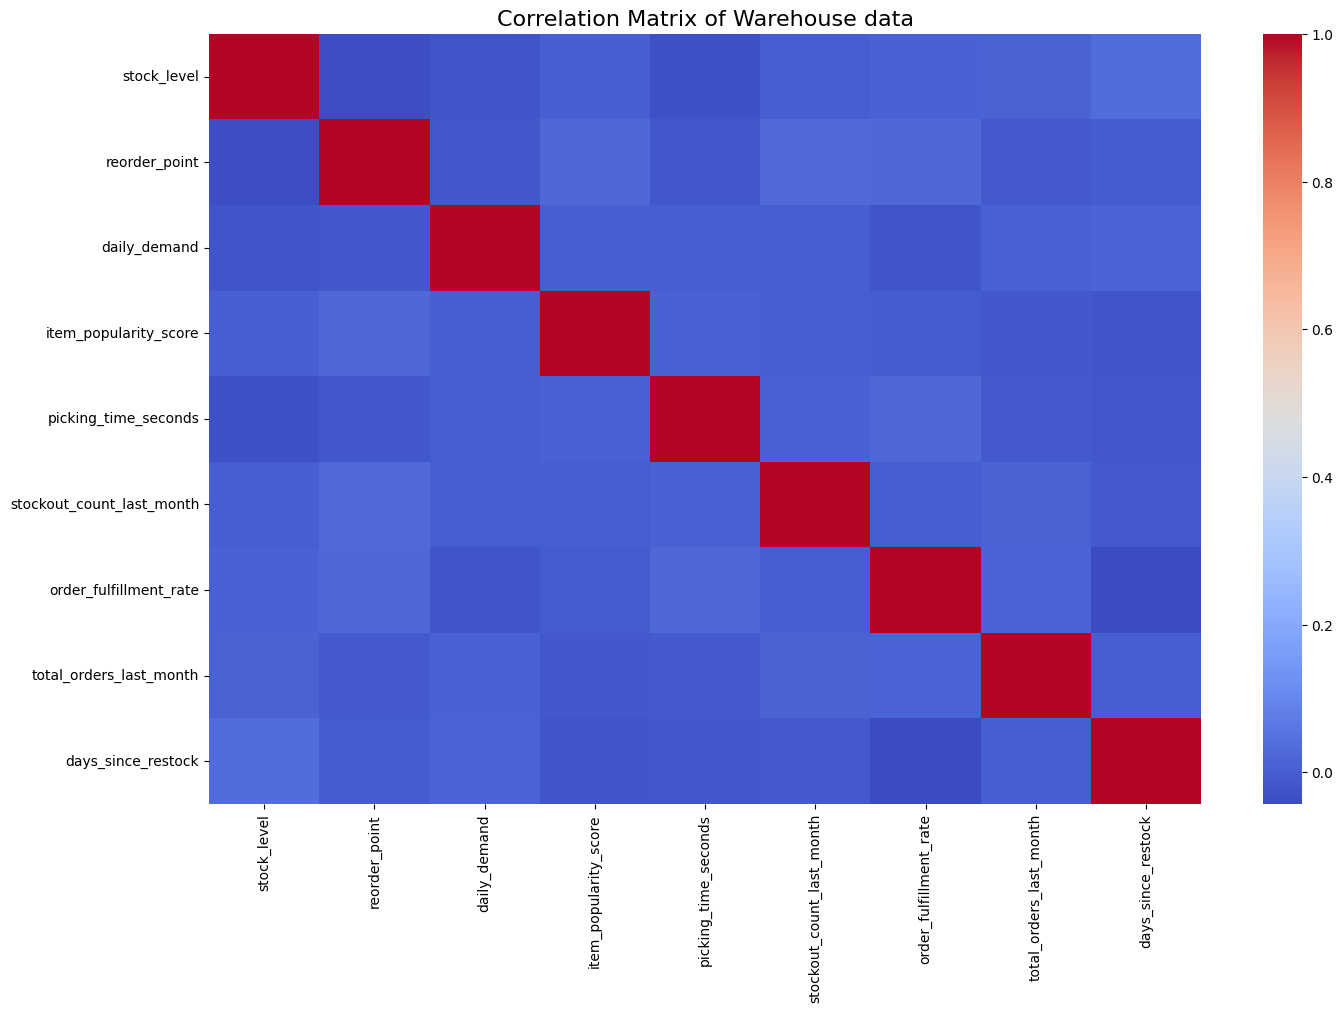

In [46]:
plt.figure(figsize=(16, 10))
numeric_cols = logistics_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = logistics_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Warehouse data', fontsize=16)
plt.show()

In [47]:
logistics_df_encoded.head()

,stock_level,reorder_point,daily_demand,item_popularity_score,storage_location_id,picking_time_seconds,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,last_restock_date,days_since_restock,category_Apparel,category_Automotive,category_Electronics,category_Groceries,category_Pharma,zone_A,zone_B,zone_C,zone_D
0,0.549061,0.123596,0.997345,0.366667,L82,0.568047,0.000000,0.333333,0.684932,2024-02-17,0.870879,False,False,False,False,True,False,True,False,False
1,0.586639,0.471910,0.455993,0.655556,L15,0.207101,0.333333,0.300000,0.722866,2024-10-01,0.247253,False,True,False,False,False,True,False,False,False
2,0.233820,0.561798,0.749030,0.577778,L4,0.988166,0.777778,0.166667,0.805058,2024-04-07,0.733516,False,False,False,True,False,False,True,False,False
3,0.680585,0.404494,0.667347,0.122222,L95,0.171598,0.000000,0.866667,0.994731,2024-01-27,0.928571,False,True,False,False,False,True,False,False,False
4,0.060543,0.505618,0.991832,0.233333,L36,0.147929,0.555556,0.433333,0.262381,2024-05-17,0.623626,False,True,False,False,False,False,False,False,True


Objective number one is to predict future demands (daily_demand, total_orders_last_month, last_restock_date, and category)

In [50]:
# Focusing on 'daily_demand' as the primary time-series feature
demand_features = ['daily_demand','total_orders_last_month', 'days_since_restock']
[c for c in logistics_df.columns if c.startswith('category')]
logistics_df_demand = logistics_df_encoded[demand_features].copy()

data = logistics_df_demand[demand_features].values
timesteps = 14

X, y = [], []
for i in range(len(data) - timesteps):
    X.append(data[i:(i + timesteps)])
    y.append(data[i + timesteps])

X, y = np.array(X), np.array(y)

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(timesteps, X_train.shape[2])),
    Dense(y_train.shape[1])
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
cp = ModelCheckpoint("lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[es, cp])

In [53]:
# Evaluate the model on the test set
loss = model_lstm.evaluate(X_test, y_test, verbose=0)
y_pred = model_lstm.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(test_mse)
print(f'Test Loss (Mean Squared Error from evaluate): {loss}')
print(f'Test MSE (calculated): {test_mse}')
print(f'Test RMSE (calculated): {rmse}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Loss (Mean Squared Error from evaluate): 0.08323849737644196
Test MSE (calculated): 0.08323849093541792
Test RMSE (calculated): 0.28851081597648626


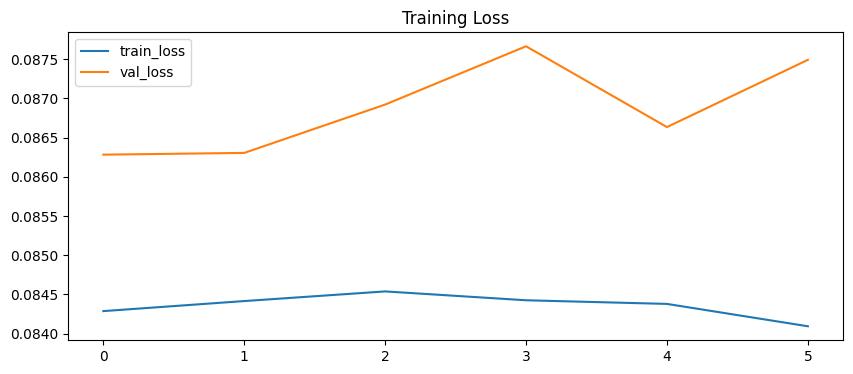

In [54]:
# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training Loss")
plt.show()

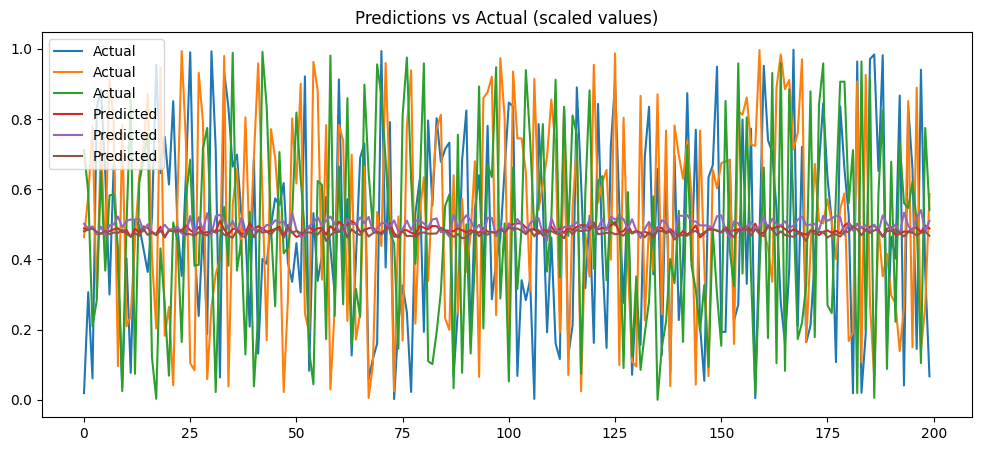

In [57]:
# Predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title("Predictions vs Actual (scaled values)")
plt.show()

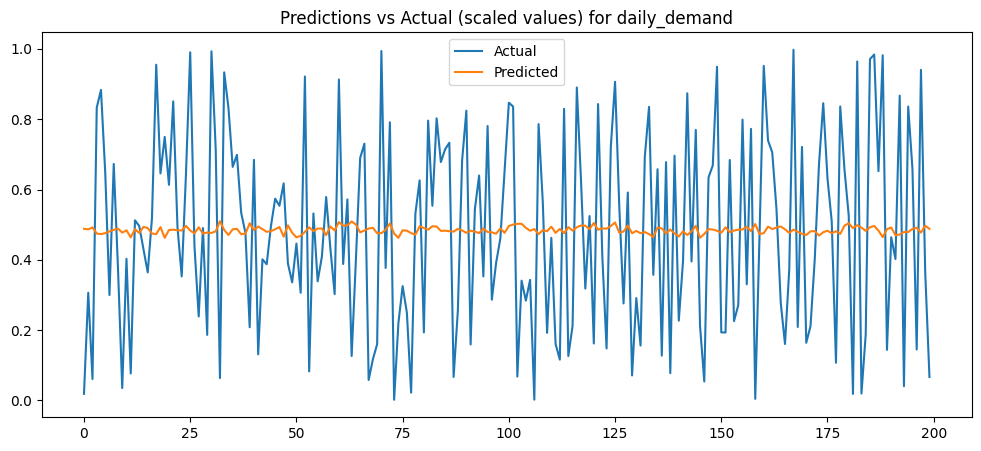

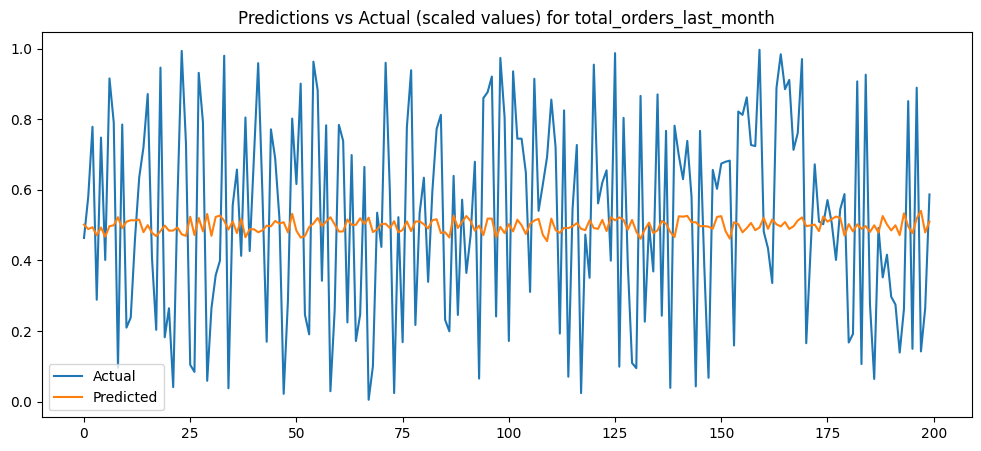

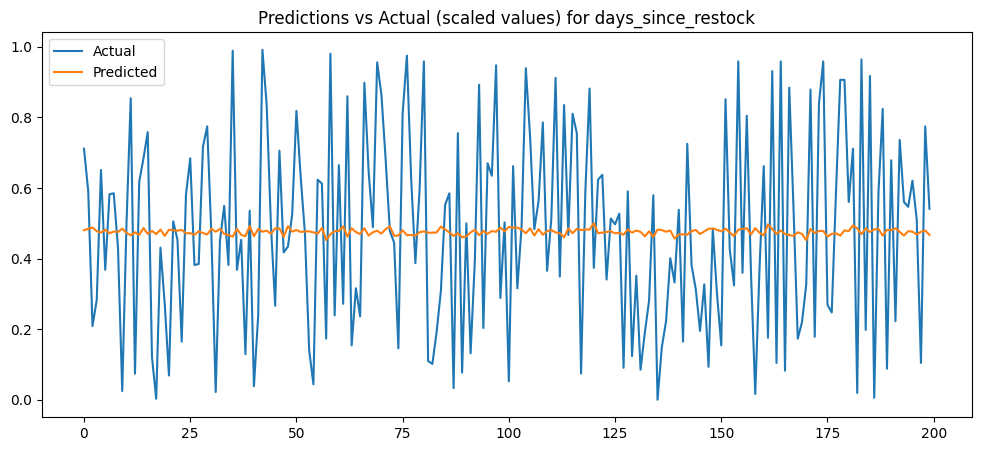

In [56]:
# Predictions vs actual for each column
predicted_columns = ['daily_demand', 'total_orders_last_month', 'days_since_restock'] # Based on the columns used for y_train

for i in range(y_test.shape[1]):
    plt.figure(figsize=(12,5))
    plt.plot(y_test[:200, i], label='Actual')
    plt.plot(y_pred[:200, i], label='Predicted')
    plt.legend()
    plt.title(f"Predictions vs Actual (scaled values) for {predicted_columns[i]}")
    plt.show()